In [ ]:
import numpy as np

import numba

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from auxiliary import *

### Geometric properties

In [2]:
# length of the rod
length = 0.1

# diameter
radius = 0.0005

# cross-section area
A = np.pi * radius**2

# second moment of area
I = np.pi * radius**4 / 4

### Material properties

In [3]:
# E-modulus
E = 200e9

# shear modulus
G =  85e9

#?? names
GA = G * A
EA = E * A
EI = E * I
GJ = 2 * G * I

# elasticity tensor
C = np.diag([GA, GA, EA, EI, EI, GJ])

### Dicretization properties

In [4]:
# number of elements
n_el = 100

# number of nodes
n_n = n_el + 1

# length of each element
h = np.ones((n_el)) * (length / n_el)

### Solution variables

Declaration in global namespace and initialization as a undeformed reference configuration

In [5]:
# centerline displacement at each node
centerline = np.zeros((3, n_n))
for i in range(n_el):
    centerline[2, i+1] = centerline[2, i] + h[i]

# rotation of crosssection at each node,
# given in axis-angle representation
rotation = np.zeros((3, n_n))

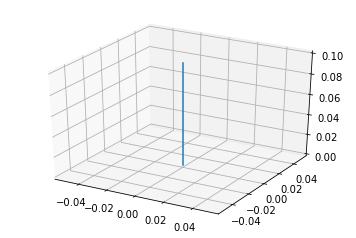

In [6]:
plot_centerline(centerline)

### Boundary conditions

The left end of the rod (i.e. s=0, node 0) is a Dirichlet boundary.

In [79]:
# force boundary condition at s = 0
#?? this is a Dirichlet boundary!!
# this code will never be really generic
b0 = np.array([0, 0, 0, 0, 0, 0])

# force boundary condition at s = 1
# ??unknown transverse load
# this should be different from 0
b1 = np.array([0, 0, 0, 0, 0, 0])

### Solving the linearized problem

In [8]:
def jacobmat():

    # global Jacobian matrix
    jac = np.zeros((6*n_n, 6*n_n))
    
    # global residual vector
    residual = np.zeros((6*n_n))
    
    # internal force  vector in inertial frame
    N = np.zeros((3))
    
    # internal moment vector
    M = np.zeros((3))
    

    # iterating over all elements
    for i in range(n_el):
        
        # update configuration ...
        # update centerline at right node of element
        centerline[:, i+1] = centerline[:, i+1] + increments[6*(i+1):6*(i+1)+3]
 
        # update rotation at right node of element
        rotation[:, i+1] = update_axis_angle(rotation[:, i+1], increments[6*(i+1)+3:6*(i+1)+6])
        
        
        # calculation of rotation matrix at midpoint of element ...
        # note that this interpolation is an approximation
        mid_axis_angle = (rotation[:, i] + rotation(:, i+1)) / 2
        if(np.linalg.norm(rotation[:, i+1] - rotation[:, i]) > np.pi)
            # required because extracted axial vector may differ by 2*pi
            print("a strange thing happened")
            # this is a hack!
            mid_axis_angle = rotation[:, i]
        mid_rotation_matrix = rotation_matrix_from_axis_angle(mid_axis_angle)
        
        
        # compute first invariant strain measure in the element
        # compute translational displacement tangent vector
        centerline_tangent = (centerline[:, i+1] - centerline[:, i]) / h[i]
        
        # first invariant strain measure
        first_strain_invariant = np.dot(rotmat.T, centerline_tangent)
        # no axial strain <=> lambda_3 = 1
        first_strain_invariant[2]  -= 1
        
        
        
        
        
        # update of ??global kappa
        
        # incremental rotation tangent vector
        delthp  = (increments[6*i+3:6*i+6] - increments[6*i-3:6*i]) / h[i]
        
        # second invariant strain measure
        
        delth   = increments[6*i-3:6*i] + (increments[6*i+3:6*i+6] - increments[6*i-3:6*i])/2
        nrm     = np.linalg.norm(delth)
        if nrm < 1e-6:
            delkapa = delthp + 0.5*np.cross(delth, delthp)
        else:
            x = sin(nrm)/nrm
            delu = delth/nrm
            delkapa = x*delthp + ((1-x)*(np.dot(delu.T, delthp)))*delu + (2*(np.sin(0.5*nrm)/nrm)**2)*np.cross(delth, delthp)
        
        kappa[:, i]   = kappa[:, i] + np.dot(rotmat.T, delkapa)

        
        
        
        

        # !!internal reactions in inertial frame
        N  = np.dot(rotmat, [C(1,1)*gama(1);C(2,2)*gama(2);C(3,3)*gama(3)])
        M  = rotmat*[C(4,4)*kapa(1,i);C(5,5)*kapa(2,i);C(6,6)*kapa(3,i)]

        


        # residual and jacobian calculation

        crossphin = np.cross(phip, N)
        
        residue[6*i-6:6*i] = residue[6*i-6:6*i] + np.hstack(-N, -(0.5*h[i])*crossphin - M)
        residue[6*i:6*i+6] = residue[6*i:6*i+6] + np.hstack(+N, -(0.5*h[i])*crossphin + M)

        C11 = np.dot(np.dot(rotmat, C[0:3, 0:3]), rotmat.T)
        C11 = (C11 + C11.T) / 2
        C12 = np.dot(np.dot(rotmat, C[0:3, 3:6]), rotmat.T)
        C21 = C12.T
        C22 = np.dot(np.dot(rotmat, C[3:6, 3:6]), rotmat.T)
        C22 = (C22 + C22.T) / 2

        phimat = skew_matrix_from_vector(phip)
        Nmat = skew_matrix_from_vector(N)
        Mmat = skew_matrix_from_vector(M)


        # material tangent stiffness (symmetric part)

        jac(6*i-5:6*i,6*i-5:6*i)        = jac(6*i-5:6*i,6*i-5:6*i)      + [ C11/h(i)     -.5*(C11*phimat)+C12/h(i); -.5*(phimat'*C11)+C21/h(i)    (phimat'*C11*phimat)*(h(i)/3)-.5*(phimat'*C12+C21*phimat)+C22/h(i)];
        jac(6*i+1:6*i+6,6*i+1:6*i+6)    = jac(6*i+1:6*i+6,6*i+1:6*i+6)  + [ C11/h(i)      .5*(C11*phimat)+C12/h(i);  .5*(phimat'*C11)+C21/h(i)    (phimat'*C11*phimat)*(h(i)/3)+.5*(phimat'*C12+C21*phimat)+C22/h(i)];
        jac(6*i+1:6*i+6,6*i-5:6*i)      = jac(6*i+1:6*i+6,6*i-5:6*i)    + [-C11/h(i)      .5*(C11*phimat)-C12/h(i); -.5*(phimat'*C11)-C21/h(i)    (phimat'*C11*phimat)*(h(i)/6)-.5*(phimat'*C12-C21*phimat)-C22/h(i)];
        jac(6*i-5:6*i,6*i+1:6*i+6)      = jac(6*i-5:6*i,6*i+1:6*i+6)    + [-C11/h(i)     -.5*(C11*phimat)-C12/h(i);  .5*(phimat'*C11)-C21/h(i)    (phimat'*C11*phimat)*(h(i)/6)+.5*(phimat'*C12-C21*phimat)-C22/h(i)];

        # geometric tangent stiffness (non-symmetric)

        jac[6*i-4:6*i, 6*i-4:6*i]       = jac(6*i-5:6*i,6*i-5:6*i)      + [zeros(3,3)    .5*Nmat;    -.5*Nmat    .5*Mmat-(phimat'*Nmat)*(h(i)/3)];
        jac[6*i+0:6*i+6,6*i:6*i+6]    = jac(6*i+1:6*i+6,6*i+1:6*i+6)  + [zeros(3,3)   -.5*Nmat;     .5*Nmat   -.5*Mmat-(phimat'*Nmat)*(h(i)/3)];
        jac[6*i+0:6*i+6,6*i-4:6*i]      = jac(6*i+1:6*i+6,6*i-5:6*i)    + [zeros(3,3)   -.5*Nmat;    -.5*Nmat   -.5*Mmat-(phimat'*Nmat)*(h(i)/6)];
        jac[6*i-4:6*i, 6*i:6*i+6]      = jac(6*i-5:6*i,6*i+1:6*i+6)    + [zeros(3,3)    .5*Nmat;     .5*Nmat    .5*Mmat-(phimat'*Nmat)*(h(i)/6)];

        # tangent due to distributive load

        # tangent due to boundary loads
    

    residue[0:6] = residue[0:6] + b0
    residue[-5:] = residue[-5:] - b1

    # calculation of displacement increment vector

    increments[6:] = np.linalg.solve(-jac[6:, 6:], residue[6:])
    
    increments_norm = norm(increments[6:])
    if increments_norm > 1:
        increments[6:] = increments[6:] / increments_norm
    
    residual_norm = np.linalg.norm(residue[6:])

    return increments_norm, residual_norm

SyntaxError: invalid syntax (<ipython-input-8-0353124138f3>, line 29)

### Main program

In [ ]:
def staticsolver():
    
    # iteration number
    iteration = 0 
    
    # initial perturbation in transverse ??displacement
    #b1[0] = 0
    #desired_load = b1[1]
    #b1[1] = 0
    
    # displacement increment vector
    increments = np.zeros((6*(n_n), 1))

    # curvature vector in each element
    kappa = np.zeros((3, n_el))
    
    # norm of global incremental displacement vector
    increments_norm = 0
    
    # norm of residual vector
    residual_norm = 0
    
    # empty array for logging transverse load (at s=1, in direction 2)
    load_data = np.array([])
    
    # empty array for logging transverse displacement (at last node, in direction 2)
    displacement_data = np.array([])
    
    
    # Newton-Rhapson iterations
    
    while(b1[1] < 1):
        iteration   = iteration + 1
    
        # display output
        print('increments_norm', increments_norm)
        print('residual_norm', residual_norm)
        print('transverse load', b1[1])
    
        # when converged, change of boundary condition (load control)
        if(increments_norm < 1e-4 and residual_norm < 1e-4):
            
            # logging
            load_data = np.append(load_data, b1[1])
            displacement_data = np.append(displacement_data, z0[1, -1])
            #??col   = [b1[1], z0[1, -1], b1[1]*L**3/(3*EI)]
            
            # increasing transverse load
            b1[1] = b1[1] + 0.1
    
    
        #plot3(z0(3,:),z0(1,:),z0(2,:));
        #pause(.001);
    
    
        increments_norm, residual_norm = jacobmat()

    #plot(data1(:,1),data1(:,2),'r');
    #plot(data1(:,1),data1(:,3),'b');
    plt.plot(np.arange(len(load_data)), load_data)

In [ ]:
staticsolver()

In [ ]:
x = np.linspace(-np.pi, np.pi, num=1000)

fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(x, np.cos(x));
axes[1].plot(x, np.sin(x));